# 1) Descentes de gradient sans contraintes
-------------------------------------------


1-1) Soit la famille de fonction: $f(x, y) = \frac{x^2}{2} + \frac{ay^2}{2} ~\forall~ a \in [1; +\inf]$

Le nombre de conditionnement d'une fonction de cette famille est équivalent au nombre de conditionnement de sa Hessienne:

$H = \begin{pmatrix} 1 & 0 \\ 0 & a \end{pmatrix}$

On choisit d'utiliser la norme $l_2$ pour calculer le nombre de conditionnement de notre matrice.
Dans ce cadre, le nombre de conditionnement est égal à: $||H||_2 \times ||H^{-1}||_2$

Dans notre cas, le nombre de conditionnement correspond à la plus grande valeur singulière divisée par la plus petite. Donc le nombre de conditionnement est $\frac{a}{1} = a$ avec $a \in [1; +\inf[$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import misc

In [2]:
def partial_derivative(ob_function, point, var=0):
    args = point
    def wraps(x):
        args[var] = x
        return ob_function(args)
    return misc.derivative(wraps, point[var], dx=1e-6)

In [3]:
def d_gd(ob_function, x):
    dim = x.shape[0]
    gradient = partial_derivative(ob_function, x, 0)
    for i in range(1, dim):
        gradient = np.vstack((gradient, partial_derivative(ob_function, x, i)))
    return gradient

def d_sgd(ob_function, x):
    dim = x.shape[0]
    sdescent = np.array([0]*dim, dtype=float).reshape(-1, 1)
    max_diff, imax_diff = sdescent[0], 0
    for i in range(dim):
        diff_i = np.linalg.norm(partial_derivative(ob_function, x, i), 2)
        if  diff_i > max_diff:
            imax_diff, max_diff = i, diff_i
    sdescent[imax_diff] = max_diff
    return sdescent

In [4]:
def build_obj(a):
    def obj_func(x):
        return (x[0] ** 2)/2 + a*(x[1] ** 2)/2
    return obj_func

def gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None),
                     verbose=False,
                     norm=2):
    """Gradient Descent.
    
    Computes minimal value of a convex function and local minimum of none convex function.
    
    Args:
        x (ndarray): initial starting point for descent.
        ob_function: objective function of optimisation problem, has input ndarray and outputs float.
        d_direction: function computing descent direction, outputs ndarray.
        rate: function computing learning rate, outputs float.
        decay_function: function computing decay, outputs float.
        tolerance (float): slack tolerance.
        max_iter (int): upper bound on number of iterations.      
        plot_f: plotting function for iteration points.
         
    Output:
        (int, int) minimizer, minimal value.
        
    """
    n_iter = 0
    decay = tolerance + 1
    y = ob_function(x)
    plot_f(x, y)
    while decay > tolerance and n_iter < max_iter:
        grad = d_direction(ob_function, x)
        x = x - rate(ob_function, n_iter) * grad
        decay = decay_function(grad[0], grad[1])
        n_iter += 1
        y = ob_function(x)
        plot_f(x, y)
    if verbose:
        print(' Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}.'.format(n_iter, x.flatten(), y[0], decay))
    if decay > tolerance:
        warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
    return ((x, y), n_iter)

In [5]:
def eval_nb_iterations(step, k=0, set_size=60, max_value=50, start=np.array([[1], [1]], dtype=float), plot=True):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))
    results = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)

        (x, y), n_iter = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        results[count, 0] = y[0]
        count+=1
    
    if (plot):
        plt.plot(results, 'g', iterations, 'r', conditioning, 'b')
        plt.show()
    return results, iterations, conditioning

**Pour un pas de 0.1**

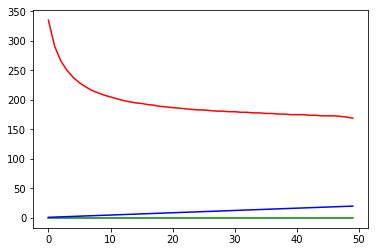

In [6]:
r, i, c = eval_nb_iterations(0.1, set_size=50, max_value=20)

On remarque deux choses pour notre famille:
- Le nombre d'itérations de la descente de gradient diminue quand le nombre de conditionnement augmente.
- A partir d'un certain nombre de conditionnement limite, la descente de gradient diverge.

Voici un exemple de divergence de l'algorithme pour les nombres de conditionnement trop élevés. Les valeurs objectives, tracées en vert, sont très éloignée de 0.

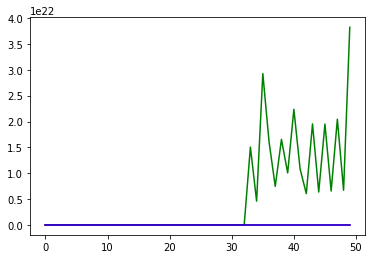

In [7]:
r, i, c = eval_nb_iterations(0.1, set_size=50, max_value=30)

On effectue maintenant des tests pour plusieurs pas différents:

**Pour un pas de 0.15:**

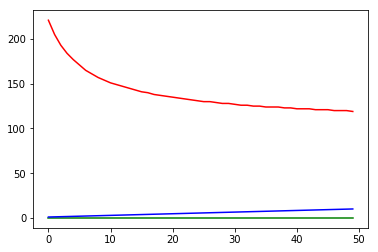

In [8]:
r, i, c = eval_nb_iterations(0.15, set_size=50, max_value=10)

**Pour un pas de 0.05:**

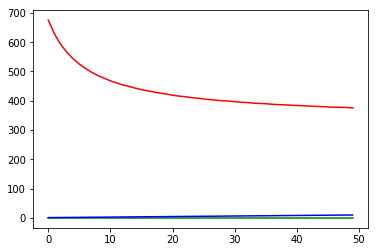

In [9]:
r, i, c = eval_nb_iterations(0.05, set_size=50, max_value=10)

**Pour un pas de 0.035:**

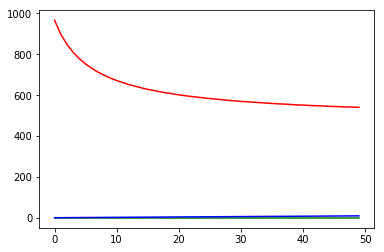

In [10]:
r, i, c = eval_nb_iterations(0.035, set_size=50, max_value=10)

**Comparons les différents pas sur un même graphe:**

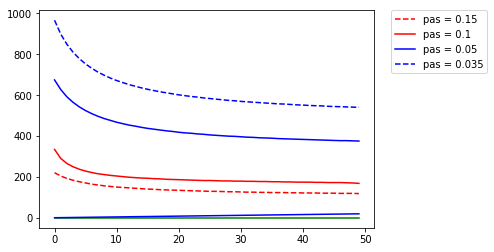

In [11]:
r1, i1, c1 = eval_nb_iterations(0.1, set_size=50, max_value=20, plot = False)
r2, i2, c2 = eval_nb_iterations(0.15, set_size=50, max_value=10, plot = False)
r3, i3, c3 = eval_nb_iterations(0.05, set_size=50, max_value=10, plot = False)
r4, i4, c4 = eval_nb_iterations(0.035, set_size=50, max_value=10, plot = False)

plt.plot(r1, 'g', c1, 'b')
plt.plot(i2, 'r--', label='pas = 0.15')
plt.plot(i1, 'r', label='pas = 0.1')
plt.plot(i3, 'b', label='pas = 0.05')
plt.plot(i4, 'b--', label='pas = 0.035')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

On remarque donc que plus le pas utilisé est elevé, plus le nombre d'itérations baisse.

Cependant, il faut bien sur faire attention à ne pas avoir un pas trop grand sinon les résultats convergeront rapidement, mais la valeur objective trouvée peut ne pas être interessante.

Il faut donc bien reflechir en amont à utiliser un pas approprié.

**Etude de l'impact du point de départ**

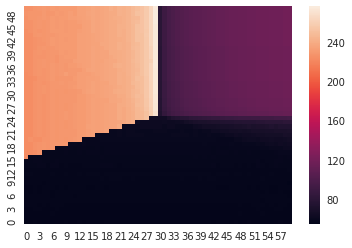

In [12]:
# norme L1

import seaborn as sns; sns.set()

a = 5
obj = build_obj(a)

x_nb_values = 60
y_nb_values = 50

X = np.linspace(-8, 8, num=x_nb_values)
Y = np.linspace(-4, 4, num=y_nb_values)

results = np.zeros((y_nb_values, x_nb_values))

for i in range(x_nb_values):
    for j in range(y_nb_values):
        start=np.array([[X[i]], [Y[j]]])

        P, n_iter = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: 0.2),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))

        results[j, i] = n_iter

ax = sns.heatmap(results)
ax.invert_yaxis()

# Heatmap
# x axis : from -8 to 8
# y axis : from -4 to 4
# Code couleur: Nombre d'itérations (noir = peu d'itérations, blanc = beaucoup d'itérations)

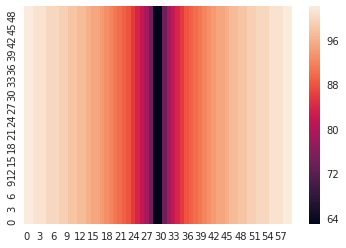

In [13]:
# Norme l2

a = 5
obj = build_obj(a)

x_nb_values = 60
y_nb_values = 50

X = np.linspace(-8, 8, num=x_nb_values)
Y = np.linspace(-4, 4, num=y_nb_values)

results = np.zeros((y_nb_values, x_nb_values))

for i in range(x_nb_values):
    for j in range(y_nb_values):
        start=np.array([[X[i]], [Y[j]]])

        P, n_iter = gradient_descent(start, obj, d_gd, 
                                     rate=(lambda x, y: 0.2),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))

        results[j, i] = n_iter

ax = sns.heatmap(results)
ax.invert_yaxis()

# Heatmap
# x axis : from -8 to 8
# y axis : from -4 to 4

**Etude de la précsion**

In [14]:
a = 3
m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
obj = build_obj(a)

start = np.array([[1], [1]], dtype=float)
P, n_iter = gradient_descent(start, obj, d_sgd, 
                             rate=(lambda x, y: 0.15),
                             decay_function=(lambda x, y: abs(x[0] - y[0])),
                             tolerance=0.0001, max_iter=1000,
                             plot_f=(lambda x, y: None),
                             verbose=True)

a = 8
m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)

obj = build_obj(a)

start = np.array([[1], [1]], dtype=float)
P, n_iter = gradient_descent(start, obj, d_sgd, 
                             rate=(lambda x, y: 0.15),
                             decay_function=(lambda x, y: abs(x[0] - y[0])),
                             tolerance=0.0001, max_iter=1000,
                             plot_f=(lambda x, y: None),
                             verbose=True)


 Iteration nu. = 149
 approx. = [1.74974562e-04 6.26533409e-05]
 ob value = 2.1196210372508144e-08
 and decay = 9.4310574081636e-05.
 Iteration nu. = 123
 approx. = [1.74974562e-04 1.72772076e-05]
 ob value = 1.650205629448597e-08
 and decay = 9.431057408342767e-05.


On remarque que la précision des valeurs trouvées est sensiblement la même pour des nombres de conditionnement identiques. Cependant, choisir un nombre de conditionnement plus grand permet de choisir un step plus faible sans impacter trop fortement les performances. De cette manière, il est peut-être possible d'augmenter la précision de la valeur objective finale.

**1-2) Comparaison nomres L1 - L2 **

In [15]:
def eval_nb_iterations_l1_l2(step, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    iterations2 = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))
    results = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)
        
        def norm2(x, y):
            v = np.zeros((2, 1))
            v[0, 0] = x
            v[1, 0] = y
            return np.linalg.norm(v, 2)

        start = np.array([[1], [1]], dtype=float)
        (x, y), n_iter = gradient_descent(start, obj, d_gd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        results[count, 0] = y[0]
        P2, n_iter2 = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=norm2,
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        iterations2[count, 0] = n_iter2
        count+=1

    # red = L2-norm
    # green = L1-norm
    plt.plot(iterations, 'r', iterations2, 'g', conditioning, 'b', results, 'y')
    plt.show()

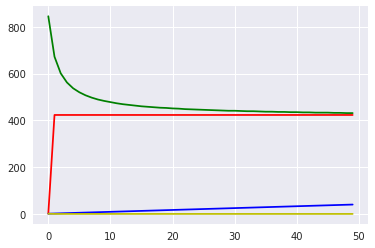

In [16]:
eval_nb_iterations_l1_l2(0.04, 50, 40)

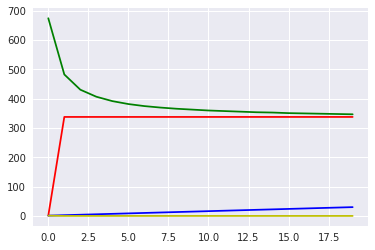

In [17]:
eval_nb_iterations_l1_l2(0.05, 20, 30)

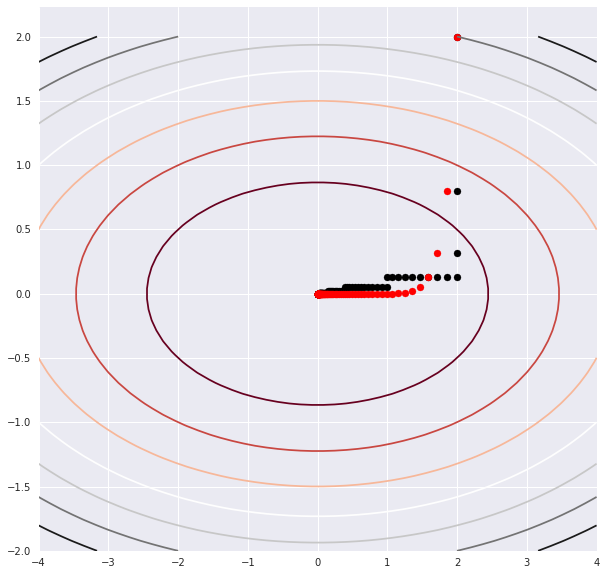

In [18]:
def plot_2d(ob_function, xmin=-4, xmax=4, ymin=-2, ymax=2, nb_pts_h=50, nb_pts_v=50):
    x1 = np.linspace(xmin, xmax, nb_pts_h)
    x2 = np.linspace(ymin, ymax, nb_pts_v)
    X, Y = np.meshgrid(x1, x2)
    Z = ob_function(np.stack((X,Y), axis=0))
    plt.contour(X, Y, Z, cmap='RdGy')

plt.figure(figsize=(10,10))
plot_2d(obj)

start = np.array([[2], [2]], dtype=float)
(x, y), n_iter = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: 0.15),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                    plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))

start = np.array([[2], [2]], dtype=float)
(x, y), n_iter = gradient_descent(start, obj, d_gd, 
                                     rate=(lambda x, y: 0.15),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                    plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='r')))

On remarque que la descente de gradient en norme L1 provoque des changements de positions suivant un axe orthogonal du plan. Cela est dû au fait que nous sommes sur une descente de gradient L1 à plus forte pente.

**1-3) learning rate scheduling**

Le but ici est de proposer une méthode pour faire évoluer le rate. Dans notre cas, nous allons implémenter un rate décroissant en fonction du nombre d'itérations. Cette méthode devrait permettre de choisir un taux plus fort et donc de converger plus vite. Elle introduit cependant le risque de réduire le rate trop rapidement.

$r_0$ et $k$ sont des hyperparamètres pour cet algorithme.

result: [1.85916158e-08]
start step: 0.3
iterations: 140


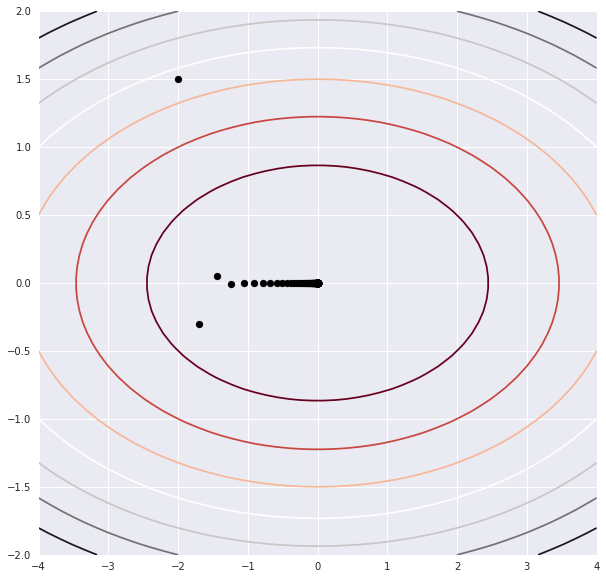

In [19]:
def plot_2d(ob_function, xmin=-4, xmax=4, ymin=-2, ymax=2, nb_pts_h=50, nb_pts_v=50):
    x1 = np.linspace(xmin, xmax, nb_pts_h)
    x2 = np.linspace(ymin, ymax, nb_pts_v)
    X, Y = np.meshgrid(x1, x2)
    Z = ob_function(np.stack((X,Y), axis=0))
    plt.contour(X, Y, Z, cmap='RdGy')

plt.figure(figsize=(10,10))
plot_2d(obj)

step = 0.3
k = 0.015

start=np.array([[-2], [1.5]], dtype=float)
a = 8

m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)

obj = build_obj(a)

(x, y), n_iter = gradient_descent(start, obj, d_gd, 
                                  rate=(lambda x, y: step * np.exp(-k * y)),
                                  tolerance=0.0001, max_iter=1000,
                                  plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))
result = y

print("result: " + str(result))
print("start step: " + str(step))
print("iterations: " + str(n_iter))

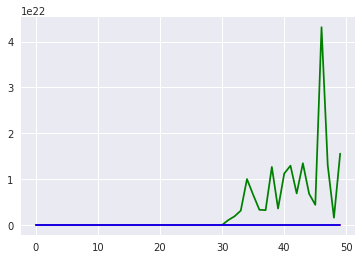

In [20]:
r, i, c = eval_nb_iterations(0.3, set_size=50, max_value=10)

On peut remarquer que pour un rate de départ de 0.3, avec des nombres de conditionnement supérieurs à environ 7, la descente sans learning rate scheduling diverge. Le learning rate scheduling permet de corriger cet état de fait.

**1-4) descentes de gradient avancées**

Descente accélérée de Nesterov:

In [21]:
def nesterov_gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None),
                     verbose=False):
    n_iter = 0
    decay = tolerance + 10  # Make sure that we get into first loop
    
    y = ob_function(x)
    y_t = x
    t = 1
    
    while decay > tolerance and n_iter < max_iter:
        curr_x = x - rate(ob_function, n_iter) * d_direction(ob_function, y_t)
        curr_t = (1 + np.sqrt(1 + 4 * t**2)) / 2
        curr_y = curr_x + ((t - 1)/curr_t) * (x - curr_x)
        
        y_t = curr_y
        x = curr_x
        t = curr_t
        
        tmp_y = ob_function(x)
        decay = decay_function(y, tmp_y)
        y = tmp_y
        n_iter += 1
        plot_f(x, y)
    if verbose:
        print(' Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}.'.format(n_iter, x.flatten(), y[0], decay))
    return ((x, y), n_iter) if decay <= tolerance else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)

In [22]:
def eval_nb_iterations_nesterov(step, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    iterations2 = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)

        start = np.array([[1], [1]], dtype=float)
        P, n_iter = nesterov_gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        P2, n_iter2 = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        iterations2[count, 0] = n_iter2
        count+=1

    # red = nesterov
    # green = classic
    plt.plot(iterations, 'r', conditioning, 'b', iterations2, 'g')
    plt.show()

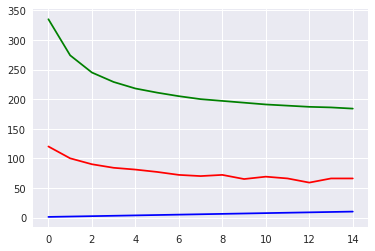

In [23]:
eval_nb_iterations_nesterov(0.1, 15, 10)

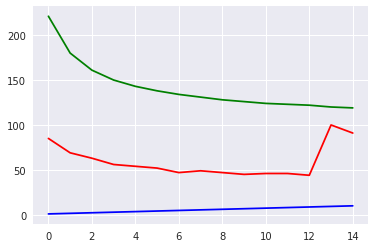

In [24]:
eval_nb_iterations_nesterov(0.15, 15, 10)

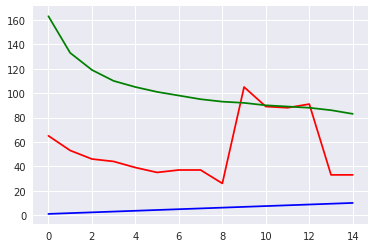

In [25]:
eval_nb_iterations_nesterov(0.2, 15, 10)

On montre que la descente de gradient de Nesterov permet de diminuer sensiblement le nombre d'itérations.

La méthode de Nesterov est adaptée aux problèmes non-convexes, dans notre cas nous avons un problème convexe et elle converge très rapidement tout de même.

** Adam optimization **

In [26]:
def adam(theta_0, obj_function, d_direction, learning_rate=0.001, b1=0.9, b2=0.999, epsilon=1e-8, max_iter=6000,
         plot_f=(lambda x, y: None)):
    m_t = 0
    v_t = 0
    t = 0
    alpha = learning_rate
    theta_t = theta_0

    for n_iter in range(max_iter):
        t += 1
        grad_t = d_direction(obj_function, theta_t)
        m_t = b1 * m_t + (1 - b1) * grad_t
        v_t = b2 * v_t + (1 - b2) * (grad_t ** 2)
        m_hat = m_t / (1 - (b1 ** t))
        v_hat = v_t / (1 - (b2 ** t))
        theta_t_prev = theta_t
        theta_t = theta_t - (alpha * m_hat) / (np.sqrt(v_hat) - epsilon)
        y = obj_function(theta_t)

        plot_f(theta_t, y)

        if np.linalg.norm(grad_t) < epsilon:
            break

    return ((theta_t, y), n_iter) if n_iter < max_iter else warnings.warn("Stopped at max_iter.", RuntimeWarning)

In [27]:
def eval_nb_iterations_adam(step, alpha, b1, b2, e, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    iterations2 = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1

        obj = build_obj(a)

        start = np.array([[1], [1]], dtype=float)
        P, n_iter = adam(start, obj, d_sgd, alpha, b1, b2, e)
        P2, n_iter2 = gradient_descent(start, obj, d_sgd,
                                       rate=(lambda x, y: step),
                                       decay_function=(lambda x, y: abs(x[0] - y[0])),
                                       tolerance=0.0001, max_iter=1000,
                                       plot_f=(lambda x, y: None))        
        iterations[count, 0] = n_iter
        iterations2[count, 0] = n_iter2
        count += 1

    # red = adam
    # green = classic
    plt.plot(iterations, 'r', conditioning, 'b', iterations2, 'g')
    plt.show()


On teste Adam avec les Hyperparametres par défaut:

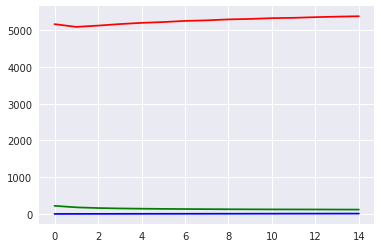

In [28]:
eval_nb_iterations_adam(0.15, 0.001, 0.9, 0.999, 1e-8, 15, 10)

Première remarque, le nombre d'itérations est très élevé.

On teste donc avec d'autres Hyperparamètre (que l'on pourrait chercher à optimiser à l'aide d'un grid search):

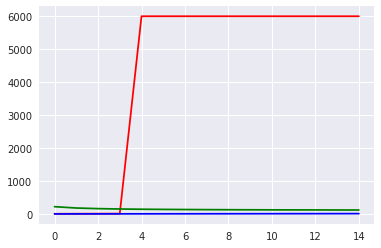

In [29]:
eval_nb_iterations_adam(0.15, 0.11, 0.1, 0.82, 0.2, 15, 10)

On peut voir qu'avec de meilleurs Hyperparametres, le nombre d'itérations baisse drastiquement pour un nombre de conditionnement inférieur a 4 (pour notre exemple).

On peut en conclure que pour un problème précis et en choisissant de bons Hyperparametres, la Adam optimization permet d'avoir de très bons résultats.

result: [0.0024512]
start step: 0.3
iterations: 20


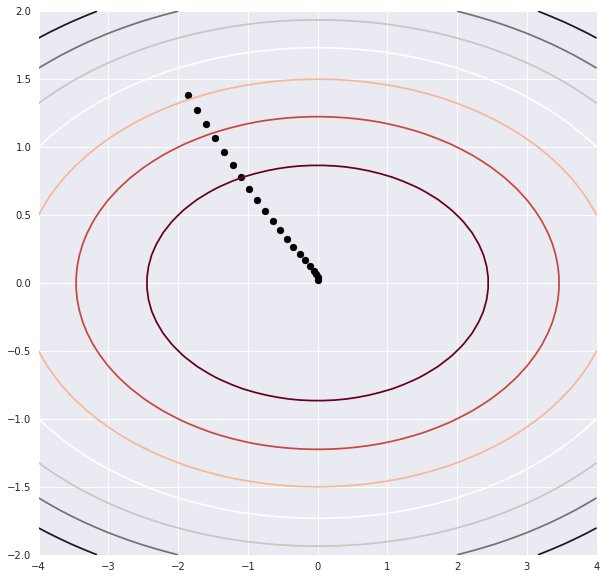

In [30]:
plt.figure(figsize=(10,10))
plot_2d(obj)

step = 0.3
k = 0.015

start=np.array([[-2], [1.5]], dtype=float)
a = 8

m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)

obj = build_obj(a)

(x, y), n_iter = adam(start, obj, d_gd, 0.11, 0.1, 0.82, 0.2, plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))
result = y

print("result: " + str(result))
print("start step: " + str(step))
print("iterations: " + str(n_iter))

## 2.1 Méthode de Newton 

**2-6 Méthode de Newton sans contraintes d'égalité **

Nous avons implémenté ci-dessous une méthode de Newton sans contraintes, qui vient donc optimiser la descente de gradient dans la recherche d'un point minimum.

Il existe deux méthodes de Newton, une qui utilise le calcul de la Hessienne et une autre qui utilise le calcul de la Jacobienne à chaque itération de l'algorithme pour déterminer l'étape suivante. La méthode que nous avons implémentée utilise le calcul de la Hessienne.

In [31]:
def Newton(x0, obj_func, hessian, gradient, max_iter=1000, plot_f=(lambda x, y: None)):
    tol = 1e-4
    x1 = 1. + x0
    for n_iter in range(max_iter):
        x0 = x1
        x1 = x0 - np.linalg.inv(hessian(x0)) @ gradient(obj_func, x0)
        
        y = obj_func(x0)
        plot_f(x0, y)
        
        if np.linalg.norm(x1 - x0) <= tol:
            break
    return x1, n_iter

result: [[-3.00175934e-05]
 [ 7.67939301e-05]]
start step: 0.3
iterations: 14


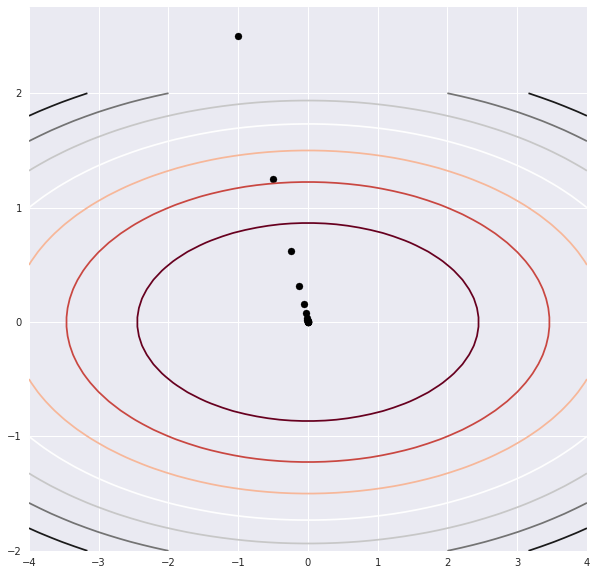

In [32]:
plt.figure(figsize=(10,10))
plot_2d(obj)

step = 0.3
k = 0.015

start=np.array([[-2], [1.5]], dtype=float)
a = 8

m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)

obj = build_obj(a)

def hess(x):
    return m

x, n_iter = Newton(start, obj, hess, d_gd, max_iter=1000, plot_f=(lambda x, y:plt.scatter(x[0], x[1], c='k')))
result = x

print("result: " + str(result))
print("start step: " + str(step))
print("iterations: " + str(n_iter))


In [33]:
def build_hess(a):
    def hess(x):
        return np.array([[1, 0], [0, a]])
    return hess

def eval_nb_iterations_newton(step, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    iterations2 = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1

        obj = build_obj(a)
        hess = build_hess(a)
        
        start = np.array([[1], [1]], dtype=float)
        
        P, n_iter = Newton(start, obj, hess, d_gd, max_iter=1000)
        P2, n_iter2 = gradient_descent(start, obj, d_sgd,
                                       rate=(lambda x, y: step),
                                       decay_function=(lambda x, y: abs(x[0] - y[0])),
                                       tolerance=0.0001, max_iter=1000,
                                       plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        iterations2[count, 0] = n_iter2
        count += 1

    # red = newton
    # green = classic
    plt.plot(iterations, 'r', conditioning, 'b', iterations2, 'g')
    plt.show()

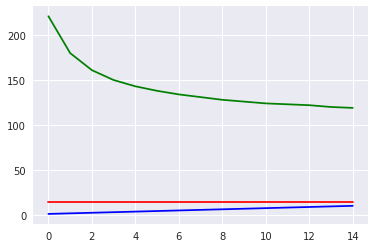

In [34]:
eval_nb_iterations_newton(0.15, 15, 10)

**Méthode de quasi-Newton:**

La méthode de quasi-newton est une méthode qui se base sur celle de Newton, mais qui permet une simplification des calculs en utilisant des approximations.

Cette méthode est donc utile lorsque les calculs dans la méthode de Newton de base deviennent très importants et très demandant en ressources. Il devient donc interessant de se pencher sur une méthode de quasi-Newton qui se sert de l'approximation de la Jacobienne utilisée dans la méthode de Newton pour optimiser les calculs via certaines propriétés.

Il existe ensuite différentes méthodes pour approximer cette matrice, malheuresement, par un manque de temps nous n'avons pas pu les implémenter et les comparer.